In [1]:
import os
os.chdir("../")

# Benchmark Specific Visualization

In [2]:
import glob
import gzip
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from modelproblem import ModelProblem
from petab.visualize import plot_problem
from weighted_quantile import weighted_quantile
from result_classes import Result,MethodResults

In [ ]:
prob_name = "Raia_CancerResearch2011"
methods = ["smc", "pmc"]
colors = sns.color_palette("tab10", n_colors=len(methods))

mod_prob = ModelProblem(prob_name)
mod_prob.initialize()

grouped_results = [MethodResults(x) for x in methods]

for method, group_obj in zip(methods, grouped_results):
	result_dir = f"results/{prob_name}/{method}/"
	fnames = glob.glob(result_dir + "*.pkl")
	for fname in fnames:
		#print(fname)
		with gzip.open(fname, "rb") as f:
			results = pickle.load(f)
		result_obj = Result(results)
		group_obj.add_result(result_obj)
print(type(mod_prob.problem))

In [ ]:
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

dummy_idx = -1

par_bounds = mod_prob.bounds #list(zip(mod_prob.problem.lb_full, mod_prob.problem.ub_full))

plt.figure(figsize=(6,4), dpi=300)
ratios = np.array([x.get_sampling_efficiency(par_bounds, dummy_idx) for x in grouped_results])
ratio_df = pd.DataFrame(columns=methods, data=ratios.T)
#print(ratio_df)
sns.boxplot(ratio_df)#, size=2)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); plt.ylabel(f"Sampling Quality");

## Select best result for each method

In [5]:
llhs = [x.get_avg_llhs() for x in grouped_results]
best_runs = [np.argmax(x) for x in llhs]
best_results = [res.all_runs[best_idx] for best_idx, res in zip(best_runs, grouped_results)]

In [ ]:
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
histtype = "step"
alpha=1

xtrue = mod_prob.petab_problem.get_x_nominal(fixed=False, scaled=True)

plt.figure(figsize=(28,20), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(6,7,i+1)
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		norm_ws = cur_result.posterior_weights
		plt.hist(cur_result.posterior_samples[:, i], lw=2, weights=norm_ws, color=colors[j], alpha=alpha,
			 cumulative=True, histtype="step", bins=50, label=cur_result.method) 
		plt.xlabel(par_name)
		plt.yticks([])
		plt.ylabel("Density")
		plt.margins(x=0.01)
	plt.axvline(x=xtrue[i], ls="--", color="k", label="Nominal")
plt.legend()
plt.tight_layout()

In [ ]:
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
xtrue = mod_prob.petab_problem.get_x_nominal(fixed=False, scaled=True)
histtype = "bar"
alpha=0.65

plt.figure(figsize=(28,20), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(6,7,i+1)
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		plt.hist(cur_result.posterior_samples[:, i], lw=2, weights=cur_result.posterior_weights, color=colors[j], alpha=alpha,
			 cumulative=False, histtype=histtype, bins=40, label=grouped_results[j].abbr) 
	#plt.axvline(x=xtrue[i], ls="--", color="k", label="Nominal", lw=0.75)
	plt.xlabel(par_name)
	plt.xticks(rotation=45)
	plt.yticks([])
	plt.ylabel("Density")
	plt.margins(x=0.01)
	plt.axvline(x=xtrue[i], ls="--", color="k", label="Nominal")
plt.legend()
plt.gca().xaxis.set_major_formatter("{x:.3f}")
#plt.xlim(left=par_bounds[i][0], right=par_bounds[i][1])

plt.tight_layout()

## Plot fits to model data

In [ ]:
CI = 0.95
UPPER_PCT = (1 - (1-CI)/2)
LOWER_PCT = ((1-CI)/2)

petab_prob = mod_prob.petab_problem
ax_dict = plot_problem(petab_problem=petab_prob,) 
fig = plt.gcf()
# Change the figure size
fig.set_size_inches(16,12)

In [47]:
obs_order

array(['observable_CD274mRNA', 'observable_IL13_cell',
       'observable_RecSurf', 'observable_SOCS3', 'observable_SOCS3mRNA',
       'observable_pIL4Ra', 'observable_pJAK2', 'observable_pSTAT5'],
      dtype=object)

['model1_data1', 'model1_data2', 'model1_data3', 'model1_data4']


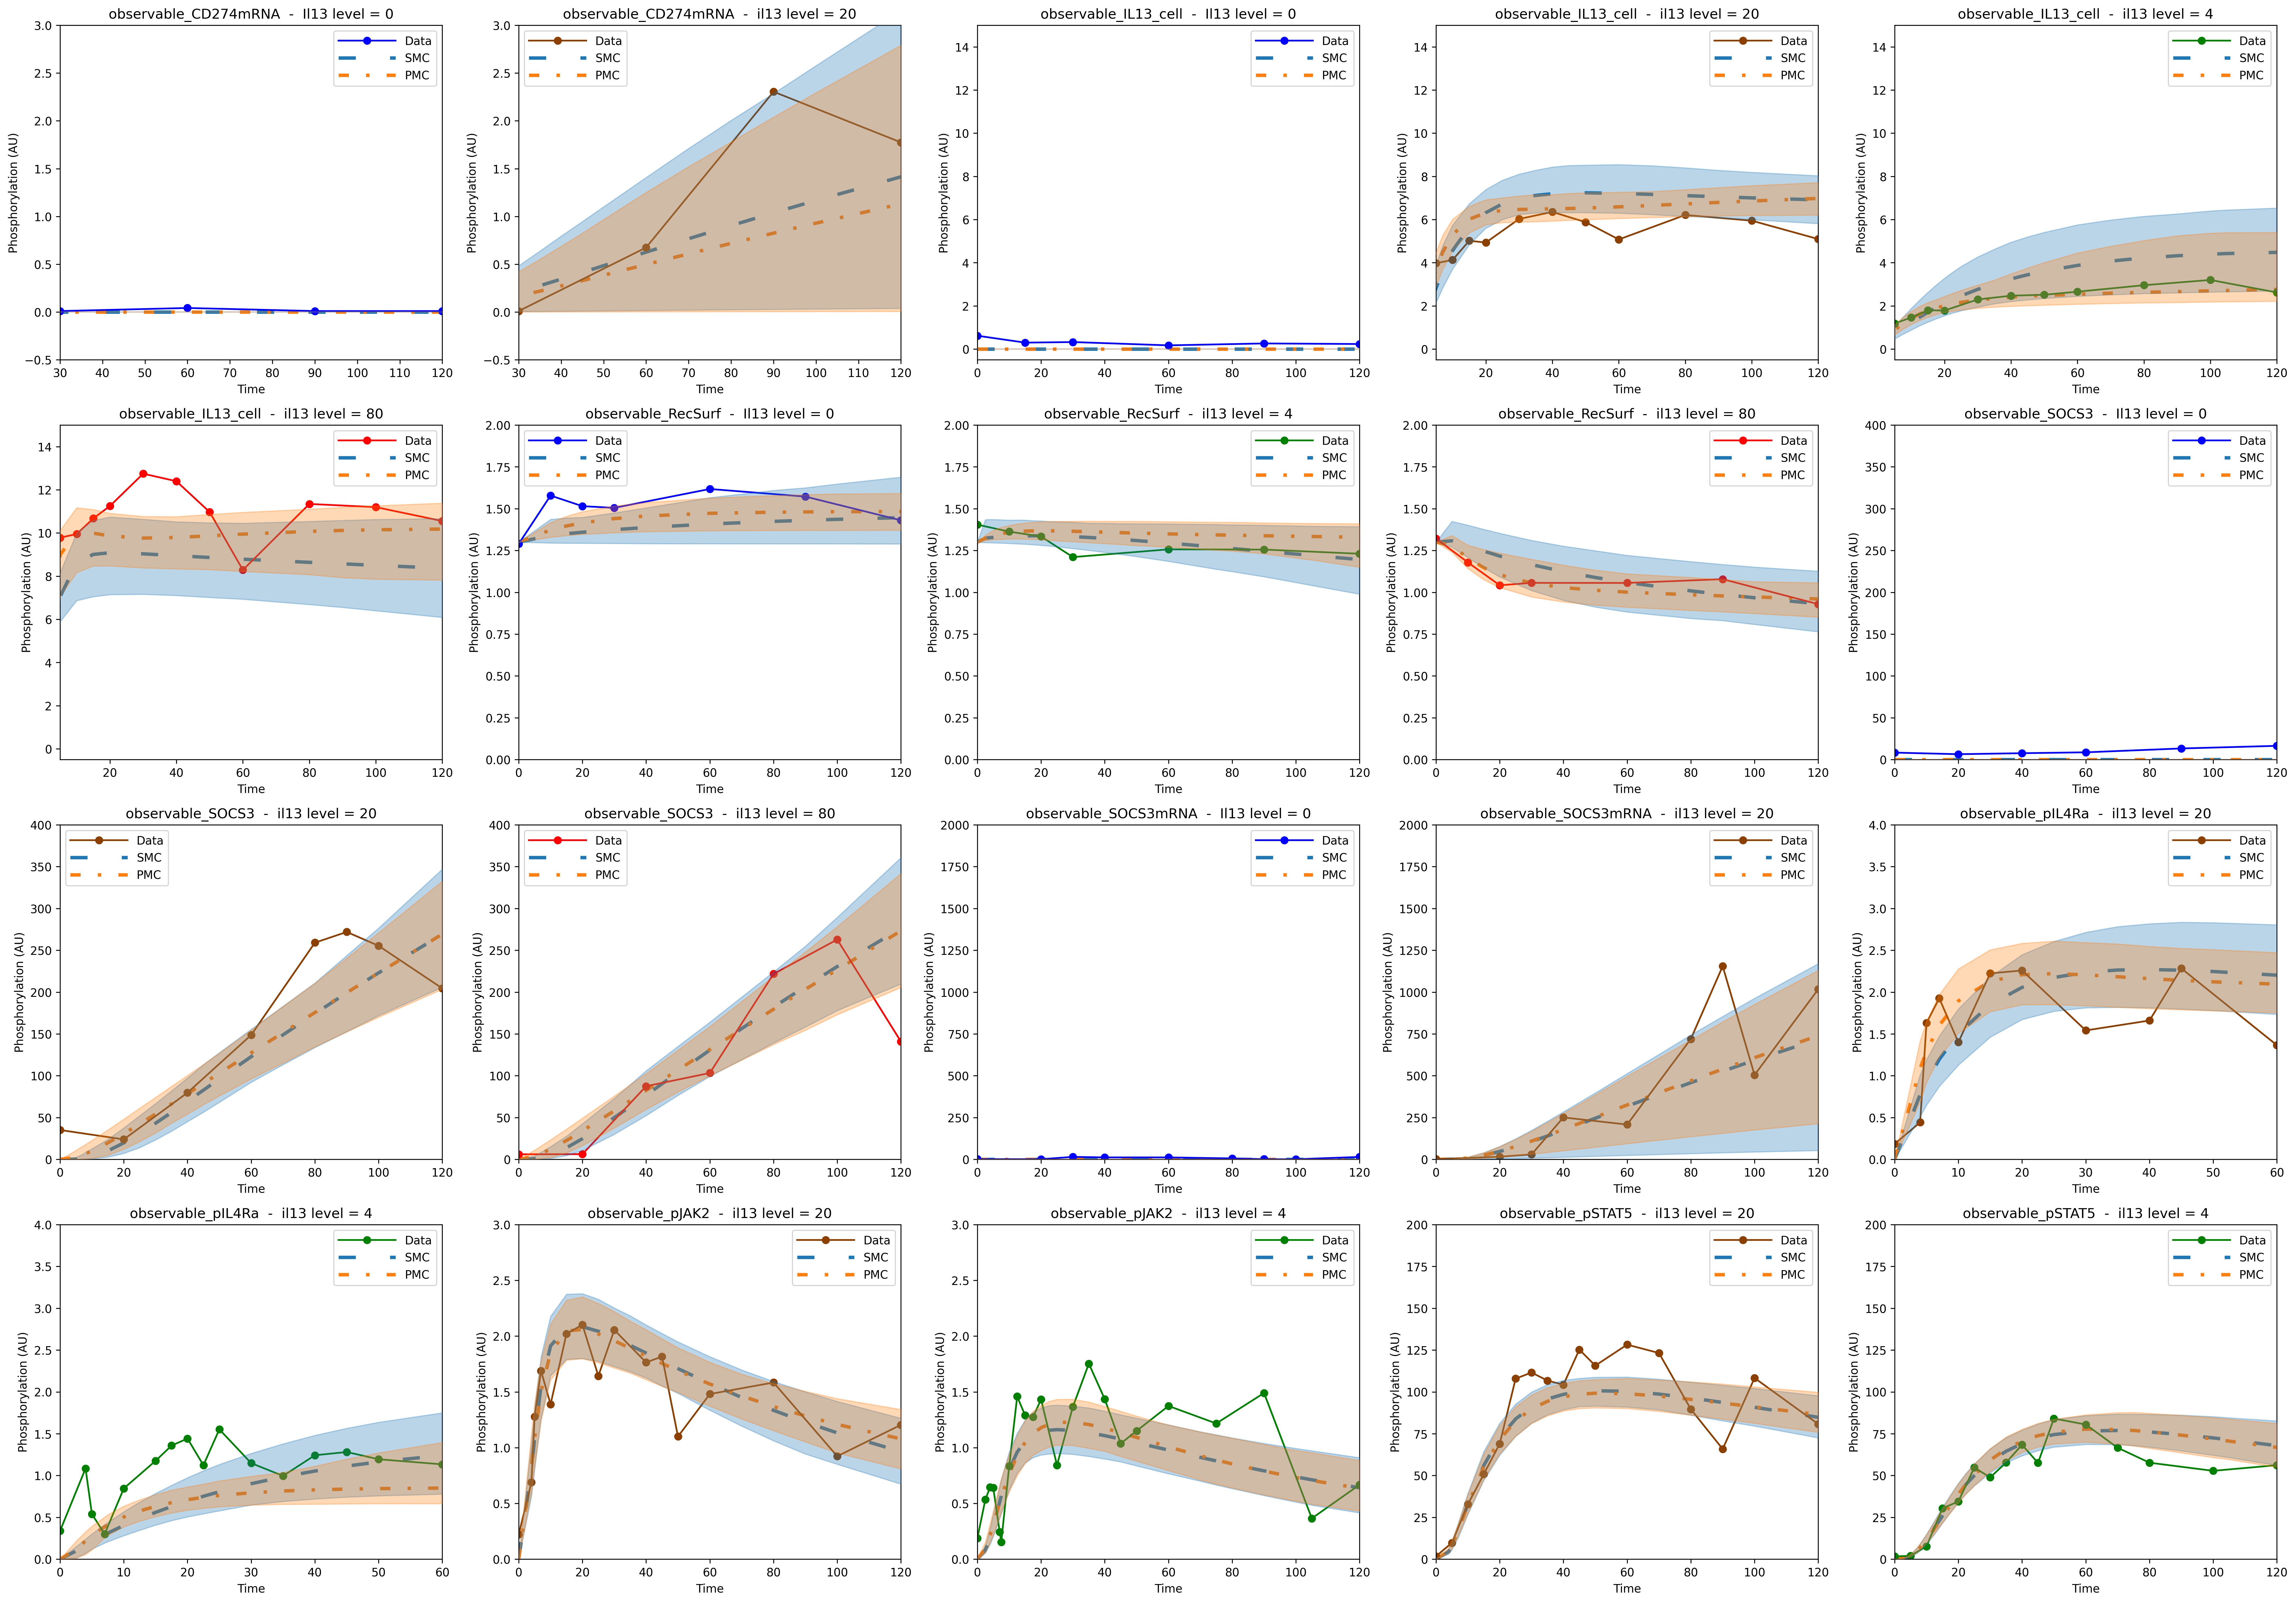

In [48]:
import petab
measure_df = petab_prob.measurement_df
# Get the names of the estimated parameters
par_names = mod_prob.problem.x_names

combos_df = measure_df.groupby(['observableId','simulationConditionId']).size().reset_index().rename(columns={0:'count'})
combos_list = list(zip(combos_df["observableId"].values, combos_df["simulationConditionId"].values))

obj = mod_prob.problem.objective
model = mod_prob.model
obs_order = petab_prob.observable_df.index.values
cond_ids = list(petab_prob.condition_df.index.values)
cond_names = petab_prob.condition_df["conditionName"].values

line_colors = ["b", "#8B4000", "g", "r"]
ylab = "Phosphorylation (AU)"
ranges = {'observable_CD274mRNA':(-0.5,3), 
			'observable_IL13_cell':(-0.5,15),
			'observable_RecSurf':(0.,2),
			'observable_SOCS3':(0.,400),
			'observable_SOCS3mRNA':(0.,2000),
			'observable_pIL4Ra':(0.,4),
			'observable_pJAK2':(0.,3),
			'observable_pSTAT5':(0.,200)
		}

plt.figure(figsize=(28,24), dpi=300)

for j, (obs_name, sim_id) in enumerate(combos_list):
	plt.subplot(5,5,j+1)
	obs_df = measure_df[(measure_df["observableId"]==obs_name) & (measure_df["simulationConditionId"]==sim_id)]

	c = line_colors[cond_ids.index(sim_id)]
	plt.plot(obs_df["time"], obs_df["measurement"], 
					color=c, marker="o", label="Data", zorder=2)
	ts = np.sort(obs_df["time"].unique())
	n_ts = len(ts)
	lss = [(0,(5,10)), (0,(3,5,1,5)), (0,(1,4))]

	for i, best in enumerate(best_results):
		pars = best.posterior_samples
		weights = best.posterior_weights

		all_sim_data = []
		
		## Collect all of the runs simulation information
		for n, par in enumerate(pars):
			sim = obj(par, mode="mode_fun", return_dict=True)#["simulation_results"]["simCondition"]
			#sim_df = amici.petab_objective.rdatas_to_simulation_df(
			#sim["rdatas"], model, measure_df)
			#print(sim.keys());
			#print(type(sim["rdatas"][0]))
			ids = [x.id for x in sim["rdatas"]]
			cond_id = ids.index(sim_id)
			rdata = sim["rdatas"][cond_id]
			species_idx = list(obs_order).index(obs_name)
			sim_ts = rdata.get("ts")
			#t_idxs = [i for i in range(len(sim_ts)) if sim_ts[i] in t]
			all_sim_data.append(rdata.get("y")[:,species_idx])
		all_sim_data = np.array(all_sim_data).T

		mean_sim_data = np.average(all_sim_data, weights=weights, axis=1)
		temp = np.array([weighted_quantile(x, [LOWER_PCT, UPPER_PCT], weights) for x in all_sim_data])

		low_sim_data = temp[:, 0]
		high_sim_data = temp[:, 1]

		plt.plot(sim_ts, mean_sim_data, lw=3, linestyle=lss[i], label=grouped_results[i].abbr, zorder=1, color=colors[i])
		plt.fill_between(sim_ts, low_sim_data, high_sim_data, zorder=3, alpha=0.3, color=colors[i])
	plt.legend(handlelength=5)
	plt.margins(x=0.02)
	plt.title(f"{obs_name}  -  {cond_names[cond_id]}")
	plt.xlabel("Time"); plt.ylabel(ylab);
	plt.xlim(left=ts[0], right=ts[-1])
	cur_range = ranges[obs_name]
	plt.ylim(*cur_range)
plt.tight_layout();